In [9]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import pandas as pd
from scipy.stats import t

np.random.seed(0)

In [10]:
# X, y = data.load_diabetes(return_X_y=True)
# X, y = data.make_regression(n_samples=1000,n_features=10,noise=10)




# 1. Sinh dữ liệu “null” (không có liên quan)
#    - X: 5 biến độc lập ~ N(0,1)
#    - Y: độc lập với X, Y ~ N(0,1)
n = 500
p = 5
iter = 2000


# X = np.random.normal(size = (n, p))
# y = np.random.normal(size = (n, 1))
# X = sm.add_constant(X)

def model_fit_unrelated(n, p):
    X = np.random.normal(size = (n, p))
    y = np.random.normal(size = (n, 1))
    X = sm.add_constant(X)

    n, p = X.shape
    beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y

    return X, y, beta_hat
def calculate_p_value(X, y, beta_hat):
    residual = y - X @  beta_hat
    sigma_squared = (residual.T @ residual) / (n - p)
    var_beta_hat = sigma_squared * np.linalg.inv(X.T @ X)
    se_beta = np.sqrt(np.diag(var_beta_hat))
    t_stats = beta_hat.flatten() / se_beta
    p_values = 2 * (1 - t.cdf(np.abs(t_stats), df = n - p))

    return p_values

def record_p_values(n, p, iter):
    p_values_list = []
    for _ in range(iter):
        X, y, beta_hat = model_fit_unrelated(n, p)
        p_values = calculate_p_value(X, y, beta_hat)

        p_values_list.append(p_values)

    return p_values_list

p_value_list = record_p_values(n, p, iter)


pvalues_df = pd.DataFrame(p_value_list, columns=['Intercept'] + [f'X{i + 1}' for i in range(p)])




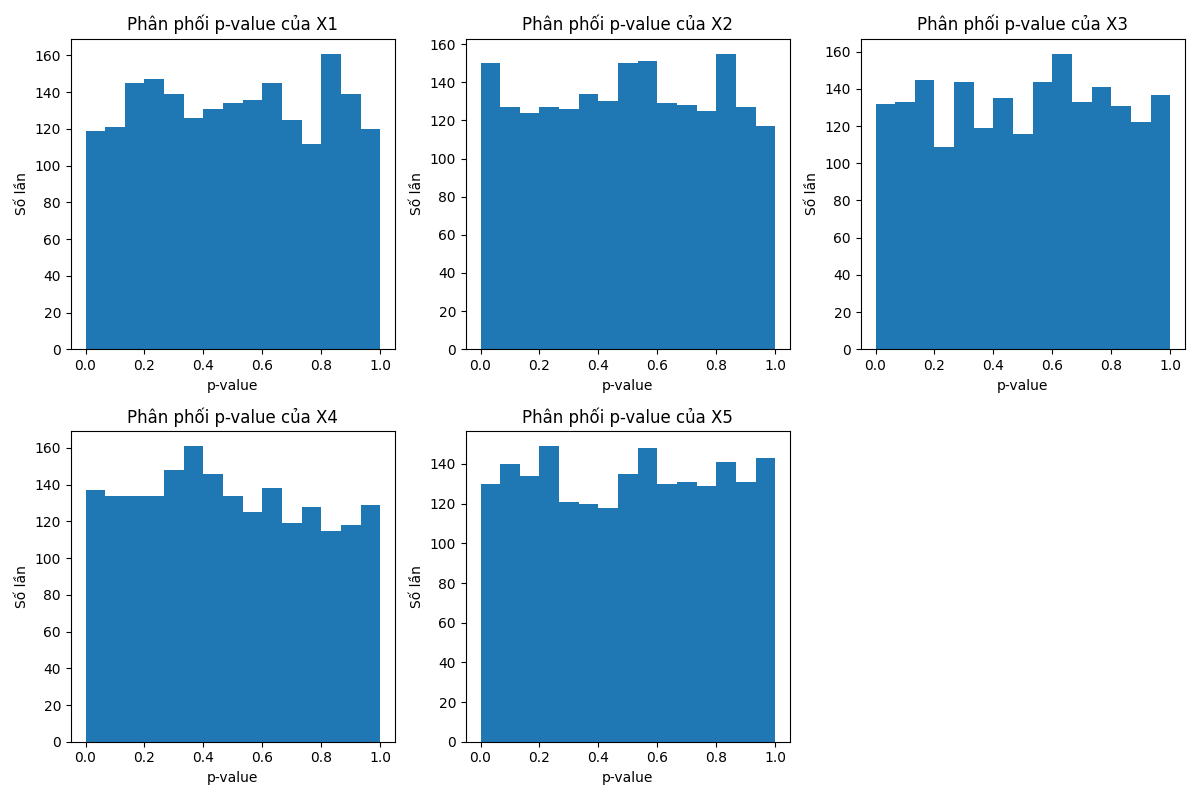

In [11]:
slope_columns = pvalues_df.columns[1:]


fig, axes = plt.subplots(2, 3, figsize = (12, 8))
axes = axes.flatten()

for idx, col in enumerate(slope_columns):
    axes[idx].hist(pvalues_df[col], bins = 15, range = (0, 1))
    axes[idx].set_title(f'Phân phối p-value của {col}')
    axes[idx].set_xlabel('p-value')
    axes[idx].set_ylabel('Số lần')








## Không quan trọng ##
for i in range(len(slope_columns), 6):
    plt.delaxes(axes[i])

plt.tight_layout()
plt.show()

Giả sử:

$$
y = \mu + \varepsilon
$$

với

$$
\varepsilon \sim \mathcal{N}(0, \sigma^2)
$$

Xét một biến ngẫu nhiên  j  trong khoảng  0  đến  p - 1 :

$$
H_0: \beta_j = 0 \quad \text{vs} \quad H_1: \beta_j \neq 0
$$

Đại lượng kiểm định (Test Statistic):

$$
T = \hat{\beta}_j
$$